## Visualisation of policies produced by the shared-NN A2C agent

In [2]:
%%capture 
#hide loading information

from datetime import datetime
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename

from gym import wrappers
import gym
import pybullet as p
import pybullet_envs
import pygame
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display
os.environ["SDL_VIDEODRIVER"] = "dummy"

import continuous_cartpole_env as continuous_cartpole
import a2cagent_continuous_shared_NN as a2cc
;

#enable tensorboard
%load_ext tensorboard

### define test() method

In [3]:
def test(num_episodes=10, env_str="ContinuousCartPoleEnv", policy="A2C061220221730ContinuousCartPoleEnv_collapse", add_branch_layer=False, use_existing_policy=True, state_normalization=False, batch_normalization=False, specification=""):
    
    """
    Visualizes a policy provided
    num_episodes: The number of episodes that will be visualized

    [Note: this test() method is loss 'sophisticated' than the one for the distinct_NN case, 
    so most of the parameters that were in place when a police was produced will have to be set manually]
    """
    # check for custom CARTPOLE ENV
    custom_cart = False
    if (env_str == "ContinuousCartPoleEnv"):
        custom_cart = True

    # load environment
    env = None
    if (custom_cart == True):
        env = continuous_cartpole.ContinuousCartPoleEnv()
    else:
        env = gym.make(env_str) 
    s0 = env.reset()

    act_space_low = env.action_space.low[0]
    act_space_high = env.action_space.high[0]
    obs_dim = env.observation_space.shape[0]

    # state normalisation
    state_space_samples = np.array(
        [env.observation_space.sample() for x in range(6400)])
    if (env_str == "CartPoleContinuousBulletEnv-v0" or custom_cart == True):
        # method does not yield reasonable results for CartPole, so we load some historical state data
        state_space_samples = np.loadtxt(os.getcwd()+"/obs-samples/norm_a.txt")

    # initiate agent
    model = a2cc.A2CAgent(s0, act_space_high, act_space_low, state_space_samples, obs_dim, state_normalization, batch_normalization,
                          use_existing_policy, add_branch_layer)

    # compile NN with inherited keras-method
    model.compile(optimizer=keras.optimizers.Adam(), loss=[
                  model.critic_loss, model.actor_loss])

    # load weights from existing model
    if use_existing_policy == True:
        model.train_on_batch(tf.stack(np.zeros((model.batch_size, model.obs_dim))), [
                             np.zeros((model.batch_size, 1)), np.zeros((model.batch_size, 2))])
        model.load_weights(
            model.my_path+'/training_continuous/shared_NN/models/' + policy+"/")

    # environment interaction
    episode_reward_sum = 0
    s = env.reset()
    episode = 1
    step = 0
    while (episode <= num_episodes):
        # obtain action distibution
        _, _ = model(s.reshape(1, -1))
        a_t, V_t = model.action_value(s.reshape(1, -1))  # choose action
        s_new, reward, done, _ = env.step(a_t.numpy()[0])  # make step

        # render1 - in jupyter notebook
        if custom_cart == True:
            if (step % (model.render_size/5) == 0):
                clear_output(wait=True)
                x = env.render()
                plt.imshow(x)
                plt.show()
        else:
            if (step % model.render_size == 0):
                clear_output(wait=True)
                x = env.render(mode='rgb_array')
                plt.imshow(x)
                plt.show()

        episode_reward_sum += reward
        s = s_new

        # handle end of episode
        if done:
            s = env.reset()
            episode_reward_sum = 0
            episode += 1

    env.close()

## "LuckyCase" phenomenon
### "LuckyCase"- Policy run for ContinuousMountainCar

Showcase for the **LuckyCase ContinuousMountainCar-policy** produced with the **continuous A2c agent with shared_N**.

It does not quite satisfy the "problem solved conditions" (average rewards >90 for 100 episodes) but it clearly has learned to use gravity to get to the yellow flag. I would be wuite contend if this performance was reproducable regularly, however that is not the case, I am unsure why this is so.. 

Please follow the README> Results section for more information on this issue

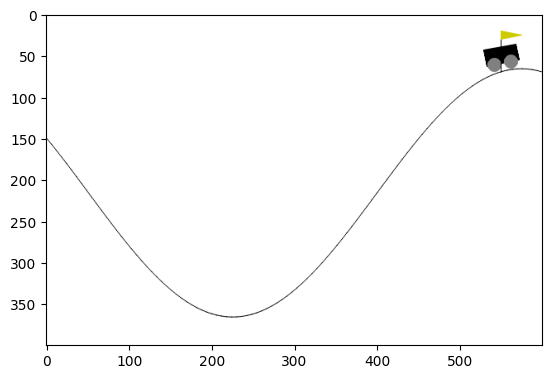

In [4]:
test(num_episodes=1, env_str="MountainCarContinuous-v0", policy="pretrained/A2C101220220847MountainCarContinuous-v0_LUCKY",
     specification="test_run", add_branch_layer=True, state_normalization=True, batch_normalization=True, use_existing_policy=True)

### "LuckyCase"- Policy run for Custom ContinuousCartPole

Showcase for the **LuckyCase ContinuousCartPole policy** produced with the **continuous A2c agent with shared_NN**.

Same issue as described for the ContinuousMountainCar, results are totally unreproducible, one within 20 runs will turn out lucky

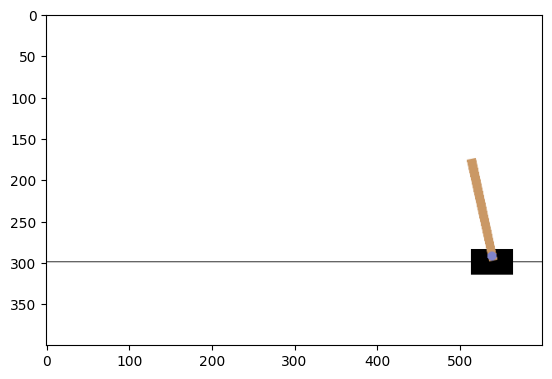

In [5]:
test(num_episodes=3, env_str="ContinuousCartPoleEnv", policy="pretrained/A2C061220221730ContinuousCartPoleEnv_LUCKY",
     specification="test_run", add_branch_layer=True, state_normalization=True, batch_normalization=True, use_existing_policy=True)

## "NotSoLuckyCase" Runs

Showcase for the **Usual CartPole policy** produced with the **continuous A2c agent with shared_NN**.

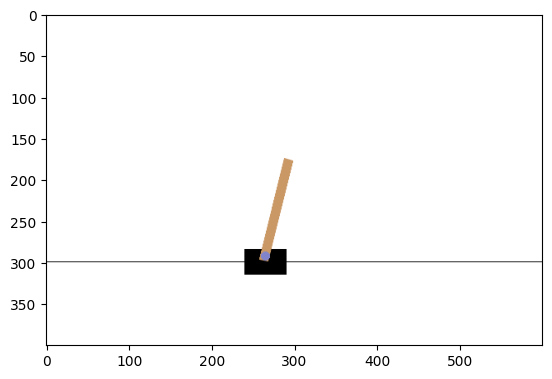

In [7]:
test(num_episodes=5, env_str="ContinuousCartPoleEnv", policy="pretrained/A2C131220222147ContinuousCartPoleEnv_UNLUCKY",
     specification="test_run", add_branch_layer=False, state_normalization=True, batch_normalization=False, use_existing_policy=True)

### You might say this does not look entirely horrible, you are right! The agent does learn, however it does so very instabily and never to a degree that will satisfy the "solved" condition! Btw in the Bullet CartPole environment the same behaviour can be witnessed.

## Training performance
via TensorBoard

To make this more clear the following graph will compare **"LuckyCase" convergence behaviour** with the **UnluckyCase** convergence behaviour. 
[NOTE: the policy we visualized from the former is taken from peak-reward times]

#### For better visibility: 
* Untick the "...MountainCarContinuousv0_LUCKY" data
* use Settings>Geneal>Relative!

#### This way you can compare running results for the LuckyCase and the the UnluckyCase of CustomCartPole and thos obtained in PyBulletCartPole



In [11]:
tb_dir=os.getcwd()+'/training_continuous/shared_NN/tensorboard/pretrained/'
%tensorboard --logdir {tb_dir}

Reusing TensorBoard on port 6006 (pid 19522), started 0:11:55 ago. (Use '!kill 19522' to kill it.)

#### You cannot see this here, but when running the training it appeared to me that the **critic-loss** used to stay very high, while the **actor-loss** decreased nicely. This is how I discovered that learning rates for the two agent-parts should be very different (the critic learns faster than the actor). The next implementation features two distinct neural networks, where this is implementable.

### Let's watch the agent fail with slightly different graphics and (supposedly) physics (using the PyBullet API) before we move on ;)

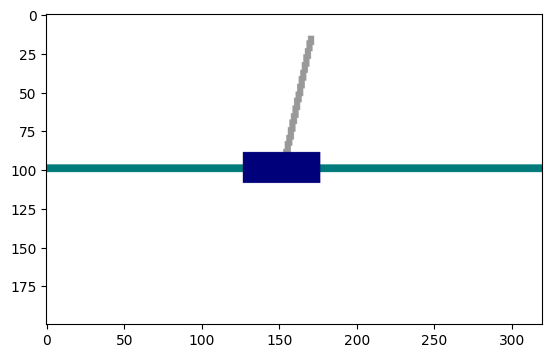

In [17]:
test(num_episodes=3, env_str="CartPoleContinuousBulletEnv-v0", policy="pretrained/A2C101220221039CartPoleContinuousBulletEnv-v0",
     specification="test_run", add_branch_layer=True, state_normalization=True, batch_normalization=True, use_existing_policy=True)

## Next Stop: *continuous_discrete_NN.ipynb*